In [2]:
from utils.plotcfg import *
from utils.analytical.utils import *

# 4. Analytical Method
This chapter presents a detailed methodology for estimating external joint torques on
a LARA8 equipped with Harmonic Drive Transmissions and dual encoders. Starting
from measuring the transmission error using the dual encoders, the approach focuses on
modelling and compensating for the transmission errors caused by known torques. The
primary hypothesis is that any remaining deformation can be attributed to external forces
by accounting for these known torques, thereby isolating the external joint torque.

To streamline the study’s complexity and achieve precise torque estimations, the research
was concentrated on a single robot joint. By focusing on a single joint, the number of
variables that could influence the accuracy of the results is decreased and a more controlled
and thorough analysis of the torque components is possible. Joint 3 was selected because
of its greater range of motion and the large torque loads it usually encounters. This
joint’s configuration and operation make it particularly suitable for studying the effects
of various torque components, both internal and external.


## 4.1. Experimental Setup and Data Collection

The robot was mounted horizontally with the base attached to a vertical plane. This
orientation effectively eliminated gravitational torque components on Joint-3, enabling
a focused study on velocity-dependant (e.g.friction) and position-dependent torques. In
this configuration, Joint-3 was rotated from its maximum limit in one direction to the
maximum limit in the opposite direction, while all other joints remained fixed at 0°, thus
covering the entire range of motion from -150° to 150°. Each recorded motion consisted of
one to-and-fro motion and was done with randomly chosen joint velocity from a uniform
distribution ranging from 0.01 rad/s to 1.15rad/s.

Data collection included recording joint velocity, joint angle, torque feedforward, load-side
encoder counts, and motor-side encoder counts at a sampling interval of 2 ms. This high-resolution data sampling ensured that detailed and accurate information was captured.

In [5]:
#run this cell to download the data
from utils.download_utils import download_and_extract_zip

data = download_and_extract_zip("analytical_dataset")
data = preprocess()

downloading data:   0%|          | 0/170923 [00:00<?, ?KB/s]

Folder downloaded and extracted successfully!


preprocessing:   0%|          | 0/44 [00:00<?, ?it/s]

As discussed in [Section 3.13](./3.0_Fundamentals.ipynb#3.1.3.-Harmonic-Drive-Transmission), transmission error $\theta_e$ can be represented by the following equation
\begin{equation}
\theta_e = \frac{\theta_m}{N }- \theta_l,\tag{4.1}
\end{equation}
where $\theta_m$ corresponds to the input motor shaft position, $N$ is the gear ratio
and $\theta_l$ pertains to the output load shaft position. This equation captures the difference between the
scaled motor position and the actual load position, effectively measuring the torsional
deformation within the Harmonic Drive Transmission. A recorded motion is randomly
sampled and its transmission error visualized below. This random sample referred hereon
as “sample” will be used throughout the rest of this chapter to demonstrate the effect of
various compensations done to it. 

Text(0.5, -0.02, '$\\mathbf{Figure\\ 4.1.:}$ Random sample from collected data .')

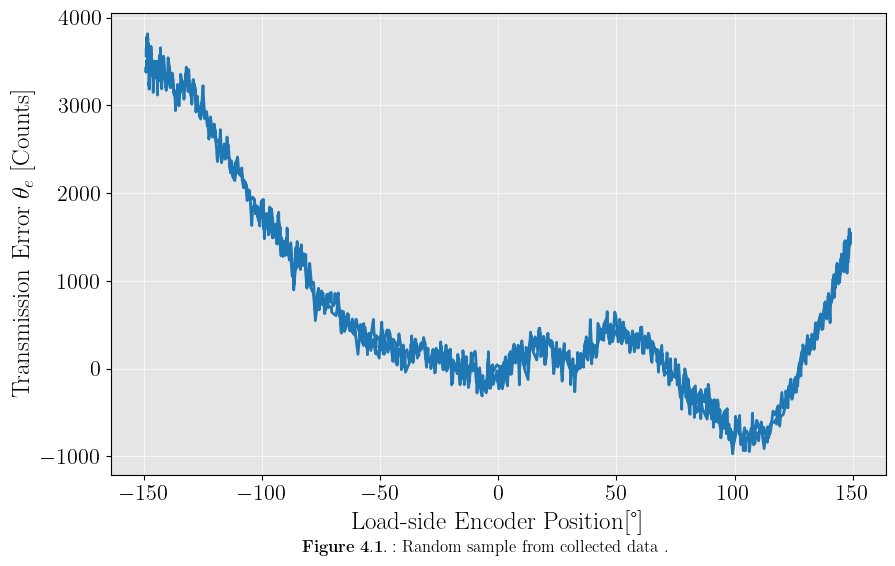

In [19]:
# A random sample from the collected data is selected, and its Transmission error is plotted
import random
random.seed(10)

sample = random.choice(list(data.keys()))
plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].encoder_motorinc_3/gear_ratio - data[sample].encoder_loadinc_3)
plt.ylabel(r'Transmission Error $\theta_e$ [Counts]')
plt.xlabel('Load-side Encoder Position[°]')
caption =  r'$\mathbf{Figure\ 4.1.:}$ Random sample from collected data .'
plt.figtext(0.5, -0.02, caption, ha='center', fontsize=12);

In Figure 4.1, the encoder data received is notably affected by significant noise. To rectify this, a low-pass filter with a cut-off frequency set at 50 Hz is applied. This filter reduces the noise while preserving the integrity of the original data. 

Text(0.5, -0.02, '$\\mathbf{Figure\\ 4.2.:}$ Kinematic error of random sample after applying low pass filter .')

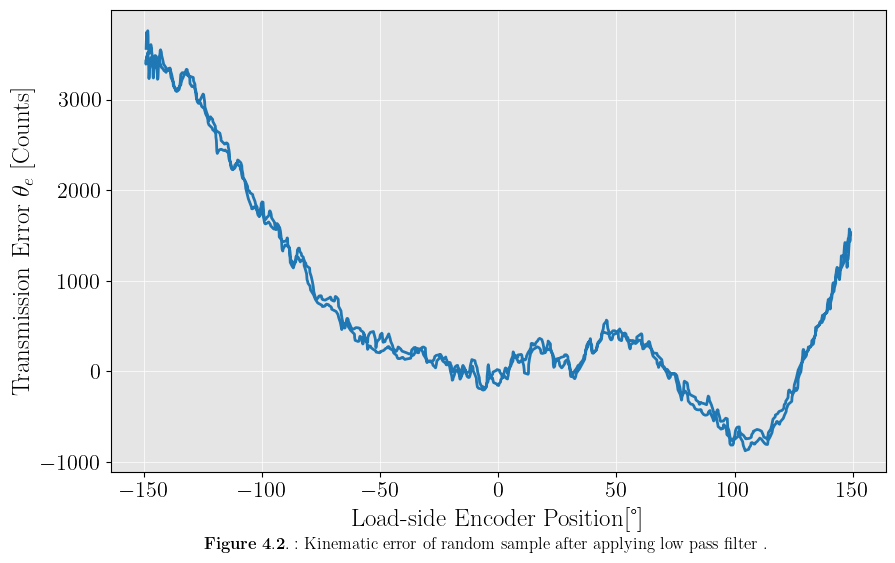

In [20]:
#apply low pass filter
for key in data:
    data[key]= filter(data[key],50)
plt.plot(data[sample].encoder_loadinc_3*count_to_deg,data[sample].filtered_motor_enc/gear_ratio - data[sample].filtered_load_enc,label ='encoder difference')
plt.ylabel(r'Transmission Error $\theta_e$ [Counts]')
plt.xlabel('Load-side Encoder Position[°]')
caption =  r'$\mathbf{Figure\ 4.2.:}$ Kinematic error of random sample after applying low pass filter .'
plt.figtext(0.5, -0.02, caption, ha='center', fontsize=12);

## 4.2. Position Based Error

To model the characteristic position-based error also referred to as the "footprint", it is essential to understand the nature of transmission errors in harmonic drive systems. One source of these errors is torque caused by gear eccentricity and tooth profile errors specific to each Harmonic Drive Transmission.
The transmission error exhibits periodic behaviour in relation to the joint position. Building on earlier research <cite id="1tmhd"><a href="#zotero%7C17740253%2FY7PHYY4G">[1]</a></cite>, <cite id="b8xyl"><a href="#zotero%7C17740253%2FERHLXZ6B">[2]</a></cite> a Fourier series model captures this periodic nature well. This model decomposes the error into sine and cosine terms, each representing different frequency components associated with the gear's rotational position. The  formula for the Fourier series used to model the transmission error is 
\begin{equation}
θ_e(θ_m,θ_l)=A_0+\Sigma^{10}_{n=1}[A_ncos(\omega_{m(n)}θ_m)+B_nsin(\omega_{m(n)}θ_m)] + \Sigma^{30}_{n=1}[C_ncos(nθ_l)+D_nsin(nθ_l)].\tag{4.1}
\end{equation}

Here, $A_0$ represents the static offset, which can be influenced by factors such as the direction of motion and any consistent bias in the system. The coefficients $A_n$,$B_nC_n$ and $D_n$ correspond to the amplitude of the cosine and sine components at each harmonic frequency $\omega_m$. These coefficients are determined based on empirical data, capturing the specific characteristics of the transmission error for a given harmonic drive.

The slowest speed among the collected data sets was a motion with $0.0113rad/s$, this was selected for further analysis to minimize the effects of velocity-dependent dynamic forces such as Coriolis and centrifugal terms. This selection ensured that the torques associated with accelerating and decelerating the joint at this low velocity were negligible and of minimal duration. This focus allowed for isolating primarily frictional and position-dependent torques, providing the data for accurately modelling the characteristic position-based error in the harmonic drive system. Figure 4.3(a) illustrates the fit of the modelled position-based error on the sampled data and Figure 4.3(b) illustrates the residual error on the sample left after compensating for the modelled position-based error.

In [21]:
#learn characteristic footprint error from the slowest data 
footprint_coeff = model_footprint(data["0.01"])
np.save("utils/analytical/footprint_coeff.npy",footprint_coeff)

for key in data:
    data[key]['modeled_footprint'] = data[key].apply(lambda row: footprint_error(footprint_coeff,row["filtered_motor_enc"], row["filtered_load_enc"]), axis=1)

Text(0.5, -0.02, '$\\mathbf{Figure\\ 4.3.:}$  (a) Footprint model fit on sampled data. (b) Residual error after compensation of footprint.')

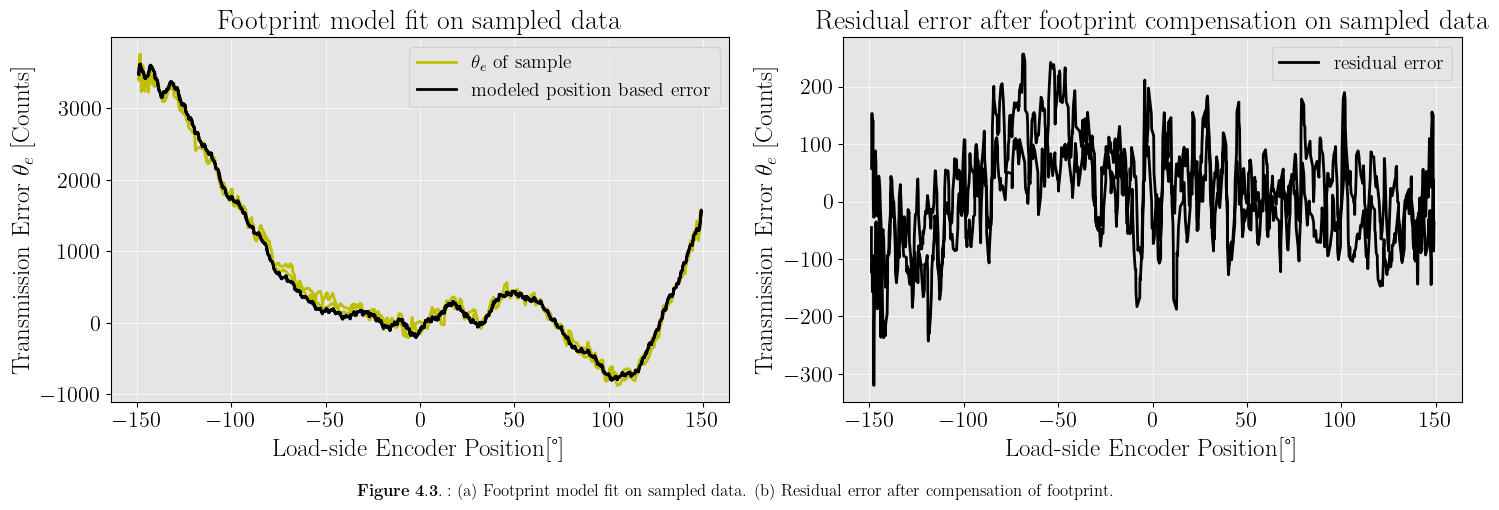

In [25]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# First plot: Footprint model fit on sampled data
ax1.plot(data[sample].encoder_loadinc_3 * count_to_deg,
         (data[sample].filtered_motor_enc / gear_ratio - data[sample].filtered_load_enc), 'y', label=r'$\theta_e$ of sample')
ax1.plot(data[sample].encoder_loadinc_3 * count_to_deg,
         data[sample].modeled_footprint / count_to_deg, 'black', label='modeled position based error')
ax1.set_ylabel(r'Transmission Error $\theta_e$ [Counts]')
ax1.set_xlabel(' Load-side Encoder Position[°]')
ax1.legend()
ax1.set_title("Footprint model fit on sampled data")

# Calculate residuals by compensating for footprint
for key in data:
    data[key]['residual_error'] = data[key].filtered_motor_enc / gear_ratio - data[key].filtered_load_enc - data[key].modeled_footprint / count_to_deg

# Second plot: Residual error after footprint compensation on randomly sampled dataset
ax2.plot(data[sample].encoder_loadinc_3 * count_to_deg,data[sample].residual_error, 'black', label='residual error')
ax2.set_ylabel(r'Transmission Error $\theta_e$ [Counts]')
ax2.set_xlabel('Load-side Encoder Position[°]')
ax2.legend()
ax2.set_title("Residual error after footprint compensation on sampled data")
plt.tight_layout()
caption =  r'$\mathbf{Figure\ 4.3.:}$  (a) Footprint model fit on sampled data. (b) Residual error after compensation of footprint.'
plt.figtext(0.5, -0.02, caption, ha='center', fontsize=12);

## 4.3. Dynamic Torque Compensation

The dynamic torque is a component of the output torque generated by the transmission.
The recorded torque feedforward [(Equation 3.8)](./3.0_Fundamentals.ipynb#3.4.1.-Equations-of-motion) is a summation of dynamic torque and
friction. In this configuration, torque caused by gravitational force is negligible. The
trajectory maintains a constant velocity, resulting in acceleration only at the beginning
and end of the motion. Therefore, apart from acceleration at joint limits, the torque
feedforward primarily consists of frictional forces, which accounts for the friction occurring
within the motor and other joint parts, including the HDT. As a portion of the friction
torque is inherently dissipated within the motor, only the fraction attributable to the
transmission error necessitates compensation. Consequently, the entire friction component
calculated for the torque feedforward is subtracted from it and the frictional torque specific
to the HDT will be modeled and compensated in a subsequent phase of this analysis

Text(0.5, -0.02, '$\\mathbf{Figure\\ 4.4.:}$  Error after compensating for footprint, dynamics on sampled data.')

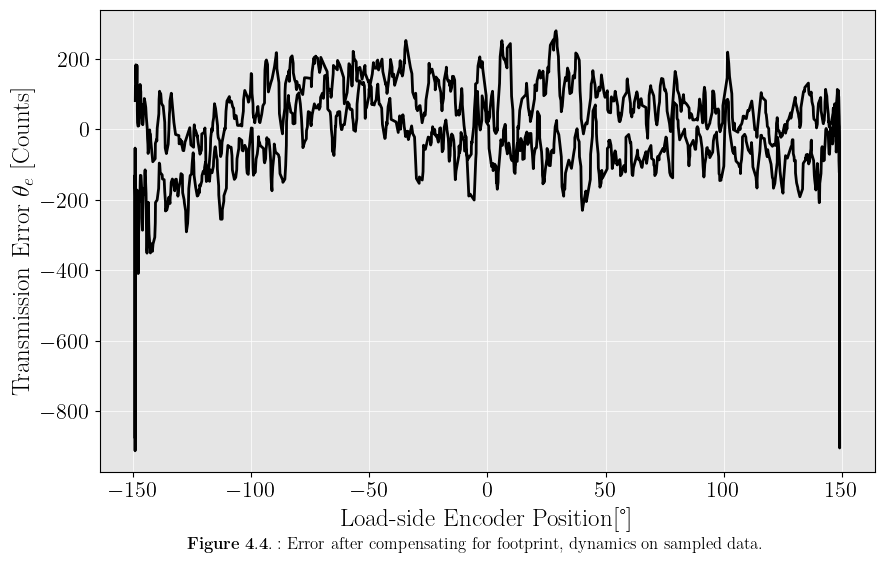

In [27]:
#compensat for dynamics(remove friction component in dynamic)
for key in data:
    data[key]['inverse_dynamics'] =  data[key].apply(lambda row:row["target_joint_torque_3"] - controller_friction_estimate(row["joint_velocity_3"]), axis=1)
    data[key]["dynamic_compensation"] = data[key].apply(lambda row: torque_to_encoder_error(row["inverse_dynamics"]), axis=1)
    data[key]["residual_error2"] = data[key].residual_error - data[key].dynamic_compensation
plt.plot(data[sample].encoder_loadinc_3*count_to_deg, data[sample].residual_error2,'black')
plt.ylabel(r'Transmission Error $\theta_e$ [Counts]')
plt.xlabel('Load-side Encoder Position[°]')
caption =  r'$\mathbf{Figure\ 4.4.:}$  Error after compensating for footprint, dynamics on sampled data.'
plt.figtext(0.5, -0.02, caption, ha='center', fontsize=12);

## 4.4. Friction compensation
The only remaining torque to be modelled is the frictional torque in the HDT, which here is modeled to be purely velocity-dependent, with no consideration given to the effects of temperature or load on friction. Using the friction model below, the parameters were identified through non-linear least squares fitting, aligning the model with the observed frictional behaviour
\begin{equation}
f(v) = a_1 (\tanh(b_1 v) - \tanh(b_2 v)) + a_2 \tanh(b_3 v) + a_3 v,\tag{}
\end{equation}
where $v$ represents the joint velocity, $a_1,a_2,a_3 ,b1,b2,b3$ are parameters that are found in the fitting. Since encoder error is synonymous with torque, the model was used in this study to map velocity to transmission error instead of the original model's intended mapping of torque to velocity <cite id="d82uy"><a href="#zotero%7C17740253%2FXA8NYAMV">[3]</a></cite>. This adaptation effectively represents the frictional torque component through transmission error, encapsulating the characteristics of the friction present in the system.

In [8]:
def friction_model(v,a1,a2,a3,b1,b2,b3):
    return a1*(np.tanh(b1*v)-np.tanh(b2*v))+a2*np.tanh(b3*v)+a3*v

Text(0.5, -0.02, '$\\mathbf{Figure\\ 4.5.:}$  (a) Friction model (b) Error after compensating for footprint, dynamics and friction on sampled data')

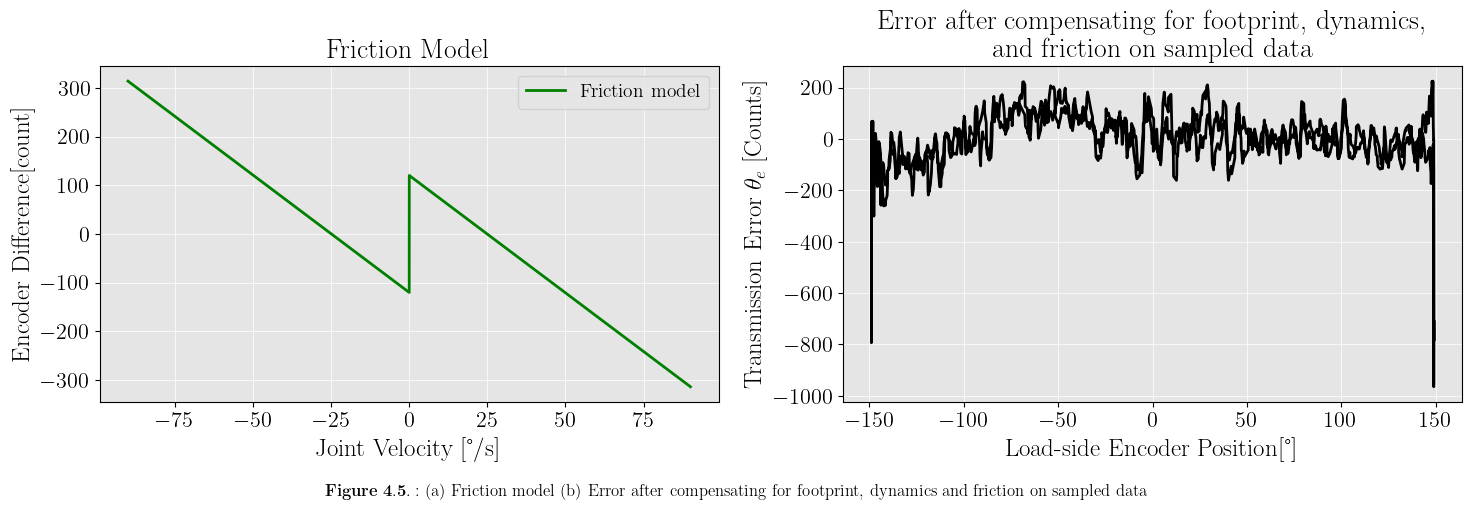

In [28]:
# Calculate parameters for the friction model
parameters, _ = curve_fit(friction_model, data[sample].joint_velocity_3 * radian_to_deg, data[sample].residual_error2)
np.save("utils/analytical/friction_coeff.npy", parameters)

y = np.arange(-90, 90, 0.01)
x = friction_model(y, *parameters)

# Compensate for friction in the data
for key in data:
    data[key]['modeled_friction'] = data[key].apply(
        lambda row: friction_model(row["filtered_joint_velocity"] * radian_to_deg, *parameters),
        axis=1
    )
    data[key]["residual_error3"] = data[key].residual_error2 - data[key].modeled_friction

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# First subplot: Friction model
axs[0].plot(y, x, 'g', label='Friction model')
axs[0].set_xlabel("Joint Velocity [°/s]")
axs[0].set_ylabel("Encoder Difference[count]")
axs[0].set_title("Friction Model")
axs[0].legend()

# Second subplot: Error after compensation
axs[1].plot(data[sample].encoder_loadinc_3 * count_to_deg, data[sample].residual_error3, 'black')
axs[1].set_ylabel(r'Transmission Error $\theta_e$ [Counts]')
axs[1].set_xlabel('Load-side Encoder Position[°]')
axs[1].set_title("Error after compensating for footprint, dynamics, \n and friction on sampled data")
plt.tight_layout()
caption =  r'$\mathbf{Figure\ 4.5.:}$  (a) Friction model (b) Error after compensating for footprint, dynamics and friction on sampled data'
plt.figtext(0.5, -0.02, caption, ha='center', fontsize=12);

## 4.5. External Torque 
The residual transmission error on the sample can now be converted to torque as implemented in [Section 3.1.3](./3.0_Fundamentals.ipynb#Stiffness-of-Harmonic-Drive-Transmission)

Text(0.5, -0.02, '$\\mathbf{Figure\\ 4.5.:}$Residual torque on sampled data')

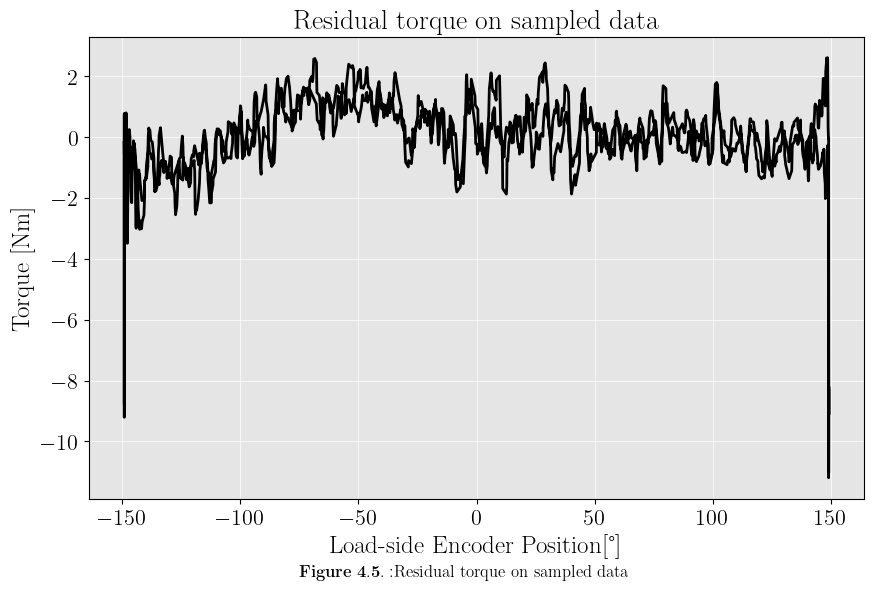

In [29]:
#convert residual transmission error to torque
for key in data:
    data[key]['torque_estimate'] = data[key].apply(lambda row: encoder_error_to_torque(row["residual_error3"]),axis=1)
plt.plot(data[sample].encoder_loadinc_3*count_to_deg, data[sample].torque_estimate,'black')
plt.ylabel('Torque [Nm]')
plt.xlabel('Load-side Encoder Position[°]')
plt.title("Residual torque on sampled data")
caption =  r'$\mathbf{Figure\ 4.6.:}$Residual torque on sampled data'
plt.figtext(0.5, -0.02, caption, ha='center', fontsize=12)

The remaining residual torque, after compensating for all known components, indicates
the presence of unmodelled torques or inaccuracies within the existing torque models.
According to our hypothesis, this residual torque corresponds to the unaccounted external
forces acting on the system. Since it was ensured that the external forces were zero during
data collection, the existence of these residuals suggests that the current models do not
fully capture all dynamic effects. These findings motivate the need for a more robust
approach, potentially incorporating multiple sources of torque information, such as motor
currents. This observation leads to the next chapter, where machine learning techniques
are employed to learn and model the external torques.

To assess the effectiveness of this approach in scenarios involving simultaneous movement of multiple joints, A test was done on a trajectory where several joints are moving at the same time. This experiment aimed to observe the impact of dynamic coupling, and how the accelerations of other joints influence the behaviour of the joint under study (Joint-3). The results are illustrated in <a href="#limitation">Figure 4.7</a>.

<figure style="text-align: center;">
<img src="utils/analytical/dpi_residual.png" id="limitation" style="width:80%">
<figcaption align = "left"> <b>Figure 4.7.: </b>Limitation of analytical model.</cite>. </figcaption>
</figure>

The results reveal a significant limitation of the Analytical method when faced with simultaneous movements across multiple joints.

<!-- BIBLIOGRAPHY START -->
<div class="csl-bib-body">
  <div class="csl-entry"><i id="zotero|17740253/Y7PHYY4G"></i>
    <div class="csl-left-margin">[1]</div><div class="csl-right-inline">P. S. Gandhi and F. H. Ghorbel, “Control of hysteresis and kinematic error nonlinearities in harmonic drives for high speed precision control applications,” in <i>Proceedings of the 2004 American Control Conference</i>, Jun. 2004, vol. 2, pp. 1141–1146 vol.2. doi: <a href="https://doi.org/10.23919/ACC.2004.1386726">10.23919/ACC.2004.1386726</a>.</div>
  </div>
  <div class="csl-entry"><i id="zotero|17740253/ERHLXZ6B"></i>
    <div class="csl-left-margin">[2]</div><div class="csl-right-inline">N. Kulkarni, “Compensation of Transmission Error in Strain Wave Gears to Reduce Vibrations in Industrial Robots,” Hochschule Schmalkalden, 2024.</div>
  </div>
  <div class="csl-entry"><i id="zotero|17740253/XA8NYAMV"></i>
    <div class="csl-left-margin">[3]</div><div class="csl-right-inline">C. Makkar, W. E. Dixon, W. G. Sawyer, and G. Hu, “A new continuously differentiable friction model for control systems design,” in <i>Proceedings, 2005 IEEE/ASME International Conference on Advanced Intelligent Mechatronics.</i>, Monterey, CA, 2005, pp. 600–605. doi: <a href="https://doi.org/10.1109/AIM.2005.1511048">10.1109/AIM.2005.1511048</a>.</div>
  </div>
</div>
<!-- BIBLIOGRAPHY END -->